<a href="https://colab.research.google.com/github/jinnyjinny/DogFaceClassification/blob/master/colab_sigol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 실행 전에 주의할 점

- GPU 가속기에서 코드 실행 (CPU에서 실행 불가)

# Dependency

In [2]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 120kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=d648266d49107e7702c97b363360a4a7da1970b378c5446e1838ce748378441f
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [44]:
import keras
import tensorflow as tf
import dlib, cv2, os 
from imutils import face_utils # imutils : 이미지  처리, dlib shape -> numpy ndarray로 자동변환
from sklearn.cluster import KMeans
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import os
import csv

In [70]:
# 전체 폴더 내 이미지

def total_rgb_ratio(detector, predictor, DOG_FOLDER_PATH):

    ##### Load Model #####
    detector = dlib.cnn_face_detection_model_v1(detector)
    predictor = dlib.shape_predictor(predictor)

    ##### Load Image #####
    dog_folder_path = DOG_FOLDER_PATH
    dog_folder_list = os.listdir(dog_folder_path)
    dog_folder_list.sort()
    # print(dog_folder_list)
    
    df1 = pd.DataFrame(columns=['index' ,'ratio'])
    for f in dog_folder_list:
        img_path = dog_folder_path + '/' + f
        img = cv2.imread(img_path)
        index = str(f.split('.')[0]) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ##### Detect Face #####
        dets = detector(img, upsample_num_times=2)
        img_result = img.copy()
        
        
        for i, d in enumerate(dets):
            #print("Detection {}: Left: {} Top: {} Right: {} Bottom: {} Confidence: {}".format(i, d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom(), d.confidence))
            x1, y1 = d.rect.left(), d.rect.top()
            x2, y2 = d.rect.right(), d.rect.bottom()
         
            cv2.rectangle(img_result, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=(255,0,0), lineType=cv2.LINE_AA)
        
        
        ##### Detect Landmarks #####
        for i, d in enumerate(dets):
            shape = predictor(img, d.rect) # detect in range of d.rect 
            shape = face_utils.shape_to_np(shape)
            shape = shape.reshape(-1) # x0 y0 x1 y1 x2 y2 x3 y3 x4 y4 x5 y5
            ##### Landmarks Ratio #####
            x3 = int(shape[6])
            y3 = int(shape[7])
            x5 = int(shape[10])
            y5 = int(shape[11])
            x2 = int(shape[4])
            y2 = int(shape[5])
            area = abs ( (x5 - x3) * (y2 - y3) - (y5 - y3) * (x2 - x3) )
            AB = ( (x5 - x2) ** 2 + (y5 - y2) ** 2 ) ** 0.5
            ratio =  (area / AB) * 0.01
            ratio = round(ratio, 4)

            df1 = df1.append(pd.DataFrame([[index, ratio]], columns=['index','ratio']), ignore_index=True)
    # print(df1)
    ##### RGB Pixel #####
    r = []
    g = []
    b = []
    for f in dog_folder_list:
        img_path = dog_folder_path + '/' + f
        img = cv2.imread(img_path)
        index = str(f.split('.')[0]) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.reshape((img.shape[0] * img.shape[1], 3)) # height, width 통합, 이 한 줄 때문에 for 문 중첩됨
        k = 5
        clt = KMeans(n_clusters = k)
        clt.fit(img)

        def centroid_histogram(clt):
            numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
            (hist, _) = np.histogram(clt.labels_, bins=numLabels)
        # normalize the histogram, such that it sums to one
            hist = hist.astype("float")
            hist /= hist.sum()
        # return the histogram
            return hist
        hist = centroid_histogram(clt)

        dictionary = {}   
        for (percent, color) in zip(hist, clt.cluster_centers_):
              startX=0
              endX = startX + (percent * 300)
              block = endX - startX
              dictionary[block] = color.astype("uint8")
              startX = endX
        rgb_max = max(dictionary.keys())
        rgb_max = dictionary[rgb_max]

        r.append(rgb_max[0])
        g.append(rgb_max[1])
        b.append(rgb_max[2])
  
    df1['r'] = r
    df1['g'] = g
    df1['b'] = b

    return df1

In [7]:
data.to_csv('/content/drive/My Drive/Cap/data.csv') 

In [72]:
# 이미지 하나씩 받는 코드

def rgb_ratio(detector, predictor, PATH):

    ##### Load Model #####
    detector = dlib.cnn_face_detection_model_v1(detector)
    predictor = dlib.shape_predictor(predictor)

    ##### Load Image #####
    img_path = PATH
    df1 = pd.DataFrame(columns=['index' ,'ratio'])
    filename, ext = os.path.splitext(os.path.basename(img_path))
    img = cv2.imread(img_path)
    index = str(img_path.split('/')[-1]) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ##### Detect Face #####
    dets = detector(img, upsample_num_times=1)
    img_result = img.copy()

    for i, d in enumerate(dets):
        x1, y1 = d.rect.left(), d.rect.top()
        x2, y2 = d.rect.right(), d.rect.bottom()
        cv2.rectangle(img_result, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=(255,0,0), lineType=cv2.LINE_AA)

    ##### Detect Landmarks #####
    for i, d in enumerate(dets):
        shape = predictor(img, d.rect) # detect in range of d.rect 
        shape = face_utils.shape_to_np(shape)
        shape = shape.reshape(-1) # x0 y0 x1 y1 x2 y2 x3 y3 x4 y4 x5 y5
        ##### Landmarks Ratio #####
        x3 = int(shape[6])
        y3 = int(shape[7])
        x5 = int(shape[10])
        y5 = int(shape[11])
        x2 = int(shape[4])
        y2 = int(shape[5])
        area = abs ( (x5 - x3) * (y2 - y3) - (y5 - y3) * (x2 - x3) )
        AB = ( (x5 - x2) ** 2 + (y5 - y2) ** 2 ) ** 0.5
        ratio =  (area / AB) * 0.01
        ratio = round(ratio, 4)
        df1 = df1.append(pd.DataFrame([[index, ratio]], columns=['index','ratio']), ignore_index=True)

    ##### RGB Pixel #####
    r = []
    g = []
    b = []
    img = img.reshape((img.shape[0] * img.shape[1], 3))
    k = 5
    clt = KMeans(n_clusters = k)
    clt.fit(img)
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)
    hist = hist.astype("float")
    hist /= hist.sum()

    dictionary = {}   
    for (percent, color) in zip(hist, clt.cluster_centers_):
          startX=0
          endX = startX + (percent * 300)
          block = endX - startX
          dictionary[block] = color.astype("uint8")
          startX = endX

    rgb_max = max(dictionary.keys())
    rgb_max = dictionary[rgb_max]

    r.append(rgb_max[0])
    g.append(rgb_max[1])
    b.append(rgb_max[2])
      
    df1['r'] = r
    df1['g'] = g
    df1['b'] = b
    # print(df1)
    return df1

In [ ]:
# 경로, 함수 불러오는 부분 
detector = '/content/drive/My Drive/Cap/dogHeadDetector.dat'
predictor = '/content/drive/My Drive/Cap/landmarkDetector.dat'
PATH = '/content/drive/My Drive/Cap/data/real/train/zzo/zzo_5.png'
DOG_FOLDER_PATH = '/content/drive/My Drive/Cap/data/total'

data = total_rgb_ratio(detector, predictor, DOG_FOLDER_PATH)
df = rgb_ratio(detector, predictor, PATH)

# Value 따로 추출하는 부분 
index = df['index'][0]
ratio = df['ratio'][0]
red = df['r'][0]
green = df['g'][0]
blue = df['b'][0]

-----------Original Image-------------


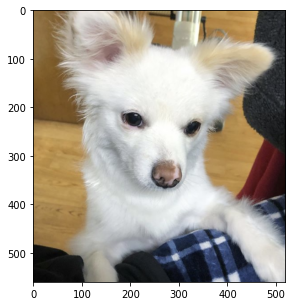

In [76]:
# 비교하고 이미지 추출하는 부분
print('-----------Original Image-------------')
PATH = '/content/drive/My Drive/Cap/data/real/train/zzo/zzo_5.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(img)

-----------Predict Image-------------


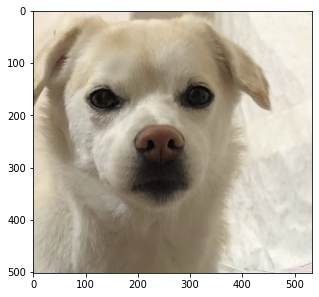

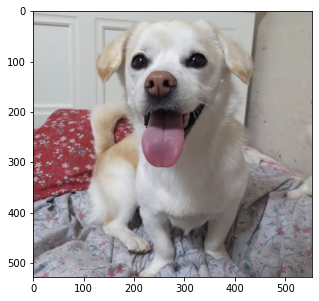

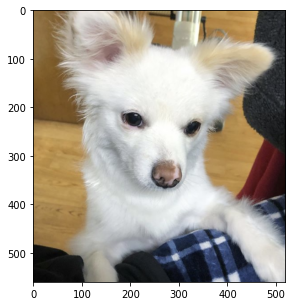

In [87]:

print('-----------Predict Image-------------')
data = pd.read_csv('/content/drive/My Drive/Cap/data.csv')
# pred = data[(data['ratio'] >= 0.5) & (data['b'] >= 200)]['index']
pred = data.query('ratio >= 0.5 & b >=200')['index']
pred = pred.values
for f in pred:
    img_path = '/content/drive/My Drive/Cap/data/total/' + f + '.png'
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5,5))
    plt.imshow(img)